# Importando bibliotecas

In [1]:
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import warnings

Retirando avisos

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Conectando ao BD local

In [3]:
dados_conexao = (
    "Driver={SQL SERVER};"
    "Server=DESKTOP-C42TKRR;"
    "Database=GoogleMerchandise;"
    "Trusted_Connection=yes;" 
)

conexao = pyodbc.connect(dados_conexao, timeout=60)


Atribuindo cada tabela a um df

In [4]:
query_normal = "SELECT * FROM google_normalizada"

df_normal = pd.read_sql_query(query_normal, conexao)


In [5]:
query_items = "SELECT * FROM items"

df_items = pd.read_sql_query(query_items, conexao)

In [6]:
query_users = "SELECT * FROM users"

df_users = pd.read_sql_query(query_users, conexao)

# Análise das bases (validações)

Analisando o contexto geral da tabela

In [7]:
df_items.head()

,id,name,brand,variant,category,price_in_usd
0,0,Google Land & Sea Cotton Cap,Google,Single Option Only,Apparel,14.0
1,1,Google KeepCup,Google,Single Option Only,New,28.0
2,2,Google Land & Sea Nalgene Water Bottle,Google,Single Option Only,Drinkware,20.0
3,3,Google Unisex Eco Tee Black,Google,LG,Uncategorized Items,22.0
4,4,Google Chicago Campus Bottle,Google,Single Option Only,Campus Collection,11.0


### 1. Tabela items

1.1 Verificando duplicidades na coluna id

In [8]:
df_items['id'].duplicated().any()

False

1.2 Verificando duplicidades na coluna name

In [9]:
df_items['name'].duplicated().any()

True

2. Verificando quais itens tem mais duplicidade e quantas são as variações

In [10]:
df_validacao = df_items[['name', 'id', 'variant']].drop_duplicates().groupby('name').agg(qtd_ids = ('id', 'count'), qtd_variacoes = ('variant', 'count')).sort_values(by='qtd_ids', ascending=False)
df_validacao.loc[(df_validacao['qtd_ids'] > 1) & (df_validacao['qtd_variacoes'] != df_validacao['qtd_ids'])]

,qtd_ids,qtd_variacoes
name,,
Google Land & Sea French Terry Sweatshirt,14,12
Google NYC Campus Zip Hoodie,9,8
Android Garden Tee Orange,9,8
Google Zip Hoodie F/C,9,8
Google Women's Grid Zip-Up,9,8
...,...,...
Google F/C Long Sleeve Tee Charcoal,2,1
Google F/C Long Sleeve Tee Ash,2,1
Google Emoji Sticker Pack,2,1


Para esse caso eu usei a seguinte abordagem, quando a qtd_ids for igual a qtd_variacoes, podemos dizer que está correto pois o item pode ter um tamanho G e outro um tamanho M.
Porém, para os itens que possuem essa diferença, constatei que um possui um valor de variação e outro não (exceto para o item "Google Land & Sea French Terry Sweatshirt"), portanto para estes casos, irei preencher a variação com "None".

Para o item "Google Land & Sea French Terry Sweatshirt" que possui dois itens sem variação.. veja abaixo:

In [11]:
df_items.loc[df_items['name'] == 'Google Land & Sea French Terry Sweatshirt']

,id,name,brand,variant,category,price_in_usd
89,89,Google Land & Sea French Terry Sweatshirt,Google,LG,Shop by Brand,44.0
303,303,Google Land & Sea French Terry Sweatshirt,Google,3XL,Shop by Brand,44.0
518,518,Google Land & Sea French Terry Sweatshirt,Google,XS,Shop by Brand,44.0
559,559,Google Land & Sea French Terry Sweatshirt,Google,XS,Shop by Brand,44.0
560,560,Google Land & Sea French Terry Sweatshirt,Google,XL,Shop by Brand,44.0
622,622,Google Land & Sea French Terry Sweatshirt,Google,XL,Shop by Brand,44.0
706,706,Google Land & Sea French Terry Sweatshirt,Google,2XL,Shop by Brand,44.0
711,711,Google Land & Sea French Terry Sweatshirt,Google,MD,Shop by Brand,44.0
758,758,Google Land & Sea French Terry Sweatshirt,Google,2XL,Shop by Brand,55.0
809,809,Google Land & Sea French Terry Sweatshirt,Google,SM,Shop by Brand,55.0


Devido a eu não conhecer regras de negócio a respeito dessa base de dados, irei excluir o registro com id 1348 e, na tabela fato, substituir todas as ocorrências do id 1348 para o id 862, aproveitando que o valor unitário é o mesmo. Isso numa situação real de trabalho deve ser analisado com as pessoas do setor responsável para definir o que será feito e de que maneira será feito, pois pode ser que apenas tenham esquecido de preencher a coluna de variação ou qualquer outro tipo de erro comum que encontramos no dia a dia como Analista de Dados. A seguir irei fazer as alterações:

OBS.: importante mencionar que essas alterações poderiam/deveriam ser feitas diretamente na view via SQL para que todas as outras pessoas pudessem consumir os dados reais, porém para que você leitor possa ter um melhor acompanhamento da minha linha de raciocínio e não precisar ir para um código SQL e voltar aqui para o Python novamente, irei realizar essas alterações diretamente aqui em Python.

In [12]:
## Preenchendo vazios com 'None'
if 'variant' in df_items.columns:
    df_items.loc[df_items['variant'] == "", 'variant'] = 'None'

In [13]:
## Removendo a linha com id 1348 da base items
df_items = df_items[df_items['id'] != 1348]

Verificando se foi realmente removido

In [14]:
df_items.loc[df_items['name'] == 'Google Land & Sea French Terry Sweatshirt']

,id,name,brand,variant,category,price_in_usd
89,89,Google Land & Sea French Terry Sweatshirt,Google,LG,Shop by Brand,44.0
303,303,Google Land & Sea French Terry Sweatshirt,Google,3XL,Shop by Brand,44.0
518,518,Google Land & Sea French Terry Sweatshirt,Google,XS,Shop by Brand,44.0
559,559,Google Land & Sea French Terry Sweatshirt,Google,XS,Shop by Brand,44.0
560,560,Google Land & Sea French Terry Sweatshirt,Google,XL,Shop by Brand,44.0
622,622,Google Land & Sea French Terry Sweatshirt,Google,XL,Shop by Brand,44.0
706,706,Google Land & Sea French Terry Sweatshirt,Google,2XL,Shop by Brand,44.0
711,711,Google Land & Sea French Terry Sweatshirt,Google,MD,Shop by Brand,44.0
758,758,Google Land & Sea French Terry Sweatshirt,Google,2XL,Shop by Brand,55.0
809,809,Google Land & Sea French Terry Sweatshirt,Google,SM,Shop by Brand,55.0


Agora vou substituir o id 1348 pelo 862 no df atribuido a tabela normalizada

In [15]:
df_normal['item_id'] = df_normal['item_id'].replace(1348, 862)

Verificando se funcionou

In [16]:
df_normal.loc[df_normal['item_id'] == 1348]

,user_id,user_country,user_device,life_time_value,first_purchase,order_id,item_id,item_name,brand,variant,category,price_in_usd,occurence,date


### 2. Tabela users

In [17]:
df_users.head()

,id,ltv,date
0,0,0,2020-10-13 05:08:47.0000000
1,1,0,2020-11-24 14:26:54.0000000
2,2,0,2020-11-24 06:19:54.0000000
3,3,231,2020-05-02 11:09:15.0000000
4,4,102,2020-11-18 15:54:38.0000000


Verificando se há duplicidades na coluna id

In [18]:
df_users['id'].duplicated().any()

False

Como não há mais o que validar nessa tabela além do id, vou seguir para responder as perguntas

### 1. Quais dispositivos geram mais compras?

Com o intuito de saber a QUANTIDADE de compras, foi necessário remover duplicidades pois a base normalizada é basicamente uma tabela fato e um mesmo pedido pode ter diversas linhas de ocorrencia.

In [19]:
df_q1 = df_normal.copy()
df_q1 = df_q1[['user_device', 'order_id']]
df_q1 = df_q1.drop_duplicates(subset='order_id')
df_q1 = df_q1.groupby('user_device').agg(
    Qtd = ('order_id', 'count')
).sort_values(by='Qtd', ascending=False).reset_index()
df_q1 = df_q1.rename(columns={'user_device' : 'Dispositivo'})
df_q1

,Dispositivo,Qtd
0,desktop,10451
1,mobile,7205
2,tablet,378


### 2. Quais países apresentam maior volume de vendas?

Leia-se volume de vendas por quantidade de itens comprados

In [20]:
df_q2 = df_normal.copy()
df_q2 = df_q2[['item_name', 'user_country']]
df_q2 = df_q2.groupby('user_country').agg(
    Qtd=('item_name', 'count')
).sort_values(by='Qtd', ascending=False).head(10).reset_index()
df_q2 = df_q2.rename(columns={'user_country' : 'País'})
df_q2

,País,Qtd
0,US,337513
1,IN,68392
2,CA,61126
3,GB,23128
4,ES,16191
5,FR,14650
6,CN,13772
7,TW,12330
8,DE,11630
9,IT,11629


### 3. Quais produtos são os mais comprados e em quais categorias eles estão?

In [21]:
df_q3 = df_normal[['item_name', 'category']].copy()
df_q3 = df_q3.groupby(['category', 'item_name']).size().reset_index(name='Qtd_Vendas')
df_q3 = df_q3.loc[df_q3.groupby('category')['Qtd_Vendas'].idxmax()]
df_q3 = df_q3.sort_values(by='Qtd_Vendas', ascending=False).reset_index(drop=True)
df_q3 = df_q3.rename(columns={
    'category' : 'Categoria',
    'item_name' : 'Item'
})
df_q3

,Categoria,Item,Qtd_Vendas
0,Apparel,Google Navy Speckled Tee,14713
1,Shop by Brand,Super G Unisex Joggers,13485
2,Accessories,Android SM S/F18 Sticker Sheet,10997
3,Lifestyle,Google Small Standard Journal Navy,9677
4,Clearance,Google Tee Yellow,9284
5,Notebooks & Journals,Android Large Trace Journal Black,8705
6,Uncategorized Items,YouTube Women's Favorite Tee White,7921
7,New,Google Heathered Pom Beanie,6970
8,Bags,Google Utility Bag Grey,4711
9,Office,Keyboard DOT Sticker,3869


### 4. Como o preço de um produto influencia sua taxa de vendas?

Criando uma coluna chamada 'qtd_vendas' e atribuindo 1 para cada linha, pois cada linha representa uma venda

In [22]:
df_q4 = df_normal.copy()
df_q4 = df_q4[df_q4['occurence'] == 'purchase']
df_q4['qtd_vendas'] = 1

Selecionando as colunas necessárias

In [23]:
df_q4 = df_q4[['item_name', 'item_id', 'qtd_vendas', 'price_in_usd']]

Agrupando por item_name e item_id

In [24]:
df_q4 = df_q4.groupby(['item_name', 'item_id']).agg({
    'price_in_usd' : 'mean',
    'qtd_vendas' : 'sum'
})

<!-- Realizando uma análise fria, é possível ver que não existe uma correlação ou ela é muito fraca, porém vou separar os valores por range e então realizar novamente -->

Plotando o gráfico

Text(0.5, 1.0, 'Quantidade de Vendas por Preço Unitário')

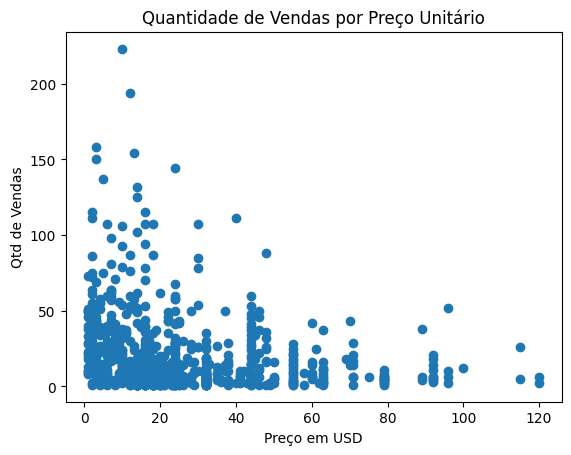

In [25]:
plt.scatter(df_q4['price_in_usd'], df_q4['qtd_vendas'])
plt.xlabel('Preço em USD')
plt.ylabel('Qtd de Vendas')
plt.title('Quantidade de Vendas por Preço Unitário')

Podemos ver que existe uma maior concentração de vendas em produtos até $40, para tornar isso mais claro, irei criar ranges (faixas de preço) para ter o gráfico mais limpo e uma visão mais clara.

Vou verificar o valor máximo e mínimo nessa base de dados

In [26]:
df_q4['price_in_usd'].describe()

count    809.000000
mean      25.105068
std       21.065083
min        1.000000
25%       13.000000
50%       18.000000
75%       32.000000
max      120.000000
Name: price_in_usd, dtype: float64

Agora irei criar o range

In [27]:
df_q4['price_range'] = pd.cut(df_q4['price_in_usd'], bins = [1, 50, 150, 250, 313],
                              labels=['$1-50', '$51-150', '$151-250', '$250+'])

Abaixo agruparei os dados pela faixa de preço, somando a quantidade de vendas

In [28]:
df_q4 = df_q4[['price_range', 'qtd_vendas']]

df_q4 = df_q4.groupby('price_range').agg({
    'qtd_vendas' : 'sum'
}).reset_index()
 

Plotando o gráfico

Text(0.5, 1.0, 'Quantidade de vendas por Faixa de Preço')

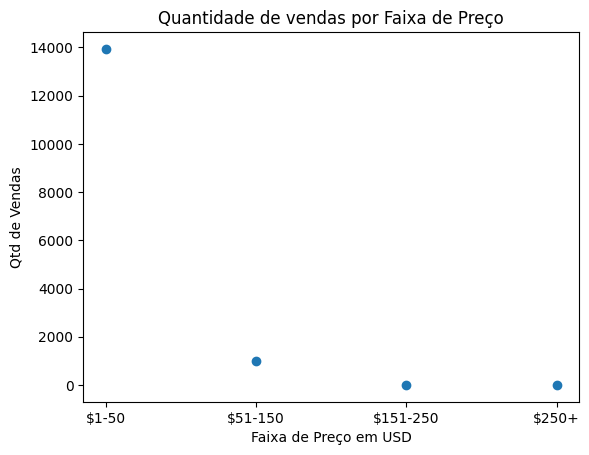

In [29]:
plt.scatter(df_q4['price_range'], df_q4['qtd_vendas'])
plt.xlabel('Faixa de Preço em USD')
plt.ylabel('Qtd de Vendas')
plt.title('Quantidade de vendas por Faixa de Preço')

Dessa forma ficou mais claro que, quanto mais baixo o valor dos produtos maior é a quantidade de vendas, sobretudo na nas faixas entre $1 e $150.

Portanto sim, o valor do produto influência na sua taxa de vendas.

### 5. Quais são os produtos mais adicionados ao carrinho, mas não comprados?

Criando um df para todos os itens adicionados ao carrinho

In [30]:
df_carrinho = df_normal.loc[(df_normal['occurence'] == 'add_to_cart')]

Criando um operador único com 3 colunas concatenadas

In [31]:
df_carrinho['occurence_id'] = df_carrinho['user_id'].astype(str) + "." + df_carrinho['order_id'].astype(str) + "." + df_carrinho['item_id'].astype(str)

Definindo apenas as colunas necessárias

In [32]:
df_carrinho = df_carrinho[['item_id', 'item_name', 'occurence_id', 'occurence']]

Agora, defini um dataframe para apenas os itens que foram de fato comprados

In [33]:
df_comprados = df_normal.loc[(df_normal['occurence'] == 'purchase')]

Criando um operador único da mesma maneira que no df_carrinho

In [34]:
df_comprados['occurence_id'] = df_comprados['user_id'].astype(str) + "." + df_comprados['order_id'].astype(str) + "." + df_comprados['item_id'].astype(str)

Selecionando as colunas desejadas

In [35]:
df_comprados = df_comprados[['item_id', 'item_name', 'occurence_id', 'occurence']]

Criando uma coluna chamada Status e preenchendo todas as linhas com "Comprado"

In [36]:
df_comprados['Status'] = 'Comprado'

Removendo duplicadas utilizando a coluna occurence_id

In [37]:
df_comprados = df_comprados.drop_duplicates(subset='occurence_id')

Realizando um merge entre os df's, para que dessa forma seja possível saber quais ocorrências estiveram no carrinho e foram de fato compradas

In [38]:
df_q5 = df_carrinho.merge(df_comprados[['occurence_id', 'Status']], on='occurence_id', how='left')

Preenchendo as linhas vazias da coluna 'Status' com 'Não comprado', para poder saber quais itens estiveram no carrinho mas não foram comprados

In [39]:
df_q5['Status'] = df_q5['Status'].fillna('Não comprado')

Filtrando para manter apenas os itens que não foram comprados

In [40]:
df_q5 = df_q5[df_q5['Status'] == 'Não comprado']

Criando uma coluna de quantidade e atribuindo 1 para todas as linhas

In [41]:
df_q5['Qtd'] = 1

Agrupando os dados por item_name

In [42]:
df_q5 = df_q5.groupby(['item_name']).agg({
    'Qtd' : 'sum'
}).reset_index().sort_values(by='Qtd', ascending=False)

Renomeando coluna

In [43]:
df_q5 = df_q5.rename(columns={
    'item_name' : 'Item'
})

Obtendo o resultado dos 10 itens que mais estiveram no carrinho e não tiveram a compra concluída

In [44]:
df_q5[['Item', 'Qtd']].head(10)

,Item,Qtd
260,Google Navy Speckled Tee,14094
379,Google Zip Hoodie F/C,13011
392,Super G Unisex Joggers,12015
365,Google Women's Striped L/S,11847
107,Google Campus Bike Eco Tee Navy,11631
148,Google Crewneck Sweatshirt Navy,10631
30,Android Large Removable Sticker Sheet,10366
42,Android SM S/F18 Sticker Sheet,10269
69,Google Badge Heavyweight Pullover Black,10139
156,Google F/C Long Sleeve Tee Charcoal,9551


Com isso, temos a relação dos itens que as pessoas mais desistiram de comprar (estiveram no carrinho mas não foram comprados)

### 6. Em quais meses, dias e horários as compras ocorrem com maior frequência?

Fazendo uma cópia do df original

In [45]:
df_q6 = df_normal.copy()

Realizando filtros 

In [46]:
df_q6 = df_q6[['order_id', 'item_id', 'occurence', 'date']]
df_q6 = df_q6[df_q6['occurence'] == 'purchase']

Criando uma coluna chamada Dia e extraindo o dia da coluna date

In [47]:
df_q6['Dia'] = df_normal['date']
df_q6['Dia'] = pd.to_datetime(df_q6['Dia'])
df_q6['Dia'] = df_q6['Dia'].dt.day

Criando uma coluna chamada Mes e extraindo o mes da coluna date

In [48]:
df_q6['Mes'] = df_normal['date']
df_q6['Mes'] = pd.to_datetime(df_q6['Mes'])
df_q6['Mes'] = df_q6['Mes'].dt.month

Criando uma coluna chamada Ano e extraindo o ano da coluna date

In [49]:
df_q6['Hora'] = df_normal['date']
df_q6['Hora'] = pd.to_datetime(df_q6['Hora'])
df_q6['Hora'] = df_q6['Hora'].dt.hour

Atribuindo qtd = 1 para todas as linhas

In [50]:
df_q6['Qtd'] = 1

A partir daqui, para cada df_q6_x fiz as mesmas coisas, agrupei pelo dia, mes ou hora e verifiquei onde teve maior concentração de compras

In [51]:
df_q6_1 = df_q6.groupby(['Dia']).agg({
    'Qtd' : 'sum'
}).reset_index().sort_values(by='Qtd', ascending=False)

In [52]:
# A linha abaixo faz com que todos os resultados sejam exibidos sem serem truncados
pd.set_option('display.max_rows', None)

df_q6_1.reset_index().drop(columns=['index'])

,Dia,Qtd
0,20,741
1,16,740
2,11,725
3,23,720
4,9,664
5,10,658
6,17,620
7,24,614
8,25,591
9,12,585


In [53]:
df_q6_2 = df_q6.groupby(['Mes']).agg({
    'Qtd' : 'sum'
}).reset_index().sort_values(by='Qtd', ascending=False)

In [54]:
df_q6_2.reset_index().drop(columns=['index'])

,Mes,Qtd
0,12,6775
1,11,6190
2,1,2590


In [55]:
df_q6_3 = df_q6.groupby(['Hora']).agg({
    'Qtd' : 'sum'
}).reset_index().sort_values(by='Qtd', ascending=False)

In [56]:
df_q6_3.reset_index().drop(columns=['index'])

,Hora,Qtd
0,22,792
1,20,729
2,8,710
3,3,706
4,4,701
5,2,697
6,17,687
7,5,686
8,16,679
9,6,662


Desta forma, temos os dias, meses e horários em que há maior concentração de vendas e, com base nisso, podemos realizar ações ou para aumentar ainda mais a quantidade de vendas nesses dias, meses ou horários , ou focar onde há baixo volume de vendas.

### 7. Quais categorias de produtos geram mais receita?

In [57]:
df_q7 = df_normal.copy()

In [58]:
df_q7 = df_q7.groupby(['category']).agg({
    'price_in_usd' : 'sum'
}).reset_index().sort_values(by='price_in_usd', ascending=False)
# Supondo que 'df' seja o seu DataFrame e 'price_in_usd' a coluna a ser formatada
df_q7['price_in_usd'] = df_q7['price_in_usd'].apply(lambda x: f"{x:,.0f}".replace(",", "."))

In [59]:
df_q7 = df_q7.rename(columns={
    'category' : 'Categoria',
    'price_in_usd' : 'Preço em USD'
})

In [60]:
df_q7.head()

,Categoria,Preço em USD
1,Apparel,10.760.619
13,New,1.161.332
16,Shop by Brand,1.134.136
0,Accessories,1.070.535
19,Uncategorized Items,798.521


### Baixando todos os df's para caso o Supervisor/Coordenador queira realizar análises via Excel

Definindo o nome das abas (sheets) por dataframe

In [61]:
dataframes = {'Q1' : df_q1,
              'Q2' : df_q2,
              'Q3' : df_q3,
              'Q4' : df_q4,
              'Q5' : df_q5,
              'Q6_1' : df_q6_1,
              'Q6_2' : df_q6_2,
              'Q6_3' : df_q6_3,
              'Q7' : df_q7}

Baixando a base

In [62]:
with pd.ExcelWriter("C:/Users/Igor/Documents/Projetos Análise de Dados/Google Merchandise Sales/Base Geral - Google Merchandise.xlsx") as writer:
    for sheet_name, df in dataframes.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)
